# SDSS: Dimensionality Reduction

In [1]:
import numpy as np
import pandas as pd
import pickle

from sklearn.manifold import Isomap
from sklearn.qda import QDA
from sklearn.decomposition import RandomizedPCA
from pandas import DataFrame, Index
from IPython.core.display import HTML
from scipy import linalg
import matplotlib as mpl
from matplotlib import colors

from sklearn.lda import LDA
from sklearn.qda import QDA

%matplotlib inline
%run scripts/performance_measures.py
%run scripts/data_processing.py
%run scripts/visualisations.py

# plot formatting
sns.set_palette("husl", 7)
mpl.rcParams["axes.titlesize"] = 16
colours = sns.color_palette()

# stylesheet for notebook
HTML(open("styles/stylesheet.css", "r").read())

In [2]:
# read in the data
sdss = pd.io.parsers.read_csv("data/sdss_dr7_photometry.csv.gz", compression="gzip", index_col=["ra", "dec"])

# save the names of the 11 feature vectors and the target column
feature_names = ["psfMag_u", "psfMag_g", "psfMag_r", "psfMag_i", "psfMag_z",
                 "petroMag_u", "petroMag_g", "petroMag_r", "petroMag_i", "petroMag_z", "petroRad_r"]
target_name = "class"

In [4]:
full_feature_matrix = np.array(sdss[feature_names])
full_target_vector = np.array(sdss['class'])
pca = RandomizedPCA(n_components=2)
proj = pca.fit_transform(full_feature_matrix)
colour_map = np.array([colours[0], colours[2], colours[3]])
class_map = {'Galaxy': 0, 'Star': 1, 'Quasar': 2}
for i in range(len(full_target_vector)):
    full_target_vector[i] = class_map[full_target_vector[i]]
full_target_vector = full_target_vector.astype(int)

In [5]:
galaxies = proj[full_target_vector==0]
stars = proj[full_target_vector==1]
quasars = proj[full_target_vector==2]

galaxies_target = full_target_vector[full_target_vector==0]
stars_target = full_target_vector[full_target_vector==1]
quasars_target = full_target_vector[full_target_vector==2]

subdata = np.concatenate((galaxies[:10000, :], stars[:10000, :], quasars[:10000, :]), axis=0)
subtarget = np.concatenate((galaxies_target[:10000], stars_target[:10000], quasars_target[:10000]), axis=0)

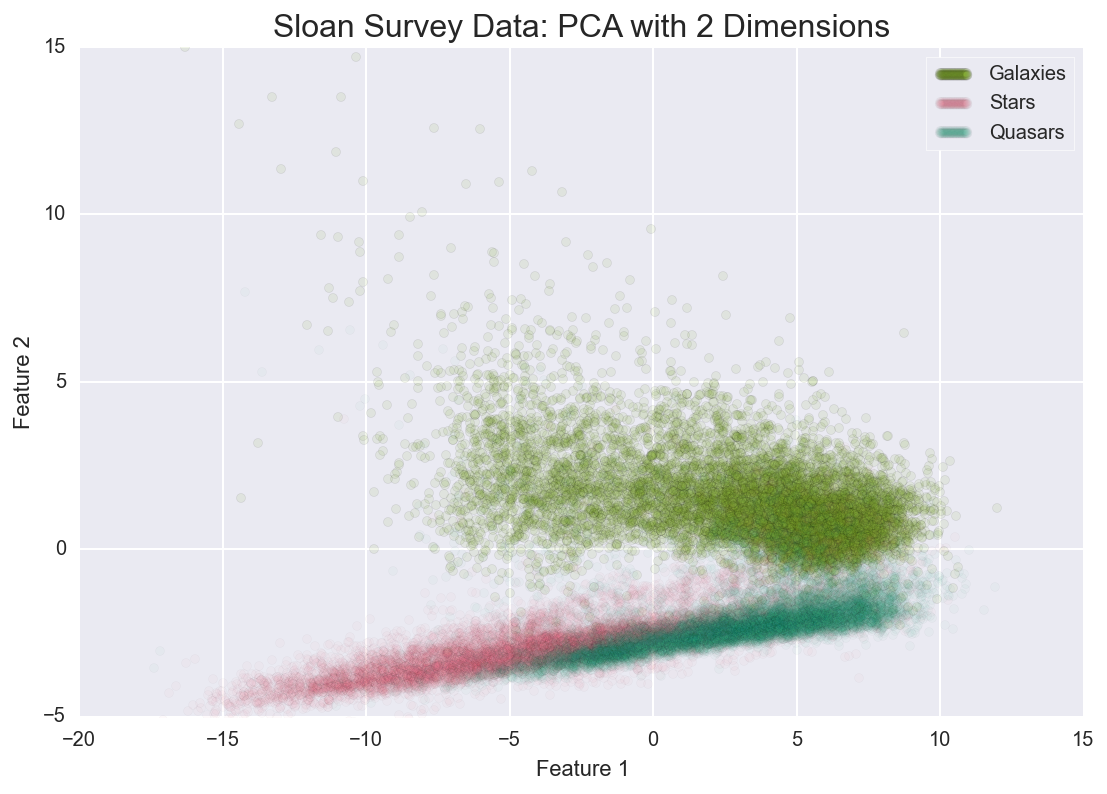

In [16]:
fig, ax = plt.subplots(figsize=(9, 6))
s_galaxies = ax.scatter(galaxies[:10000, 0], galaxies[:10000, 1], c=colour_map[1], alpha=0.1)
s_stars = ax.scatter(stars[:10000, 0], stars[:10000, 1], c=colour_map[0], alpha=0.03)
s_quasars = ax.scatter(quasars[:10000, 0], quasars[:10000, 1], c=colour_map[2], alpha=0.03)
ax.legend((s_galaxies, s_stars, s_quasars),
           ('Galaxies', 'Stars', 'Quasars'),
           scatterpoints=100,
           loc='upper right',
           frameon=True,
           ncol=1)
ax.set_ylim([-5, 15])
ax.set_xlim([-20, 15])
ax.set_title('Sloan Survey Data: PCA with 2 Dimensions')
ax.set_xlabel('Feature 1')
ax.set_ylabel('Feature 2')
plt.show()

In [18]:
qda = QDA()
y_pred = qda.fit(subdata, subtarget, store_covariances=True).predict(subdata)

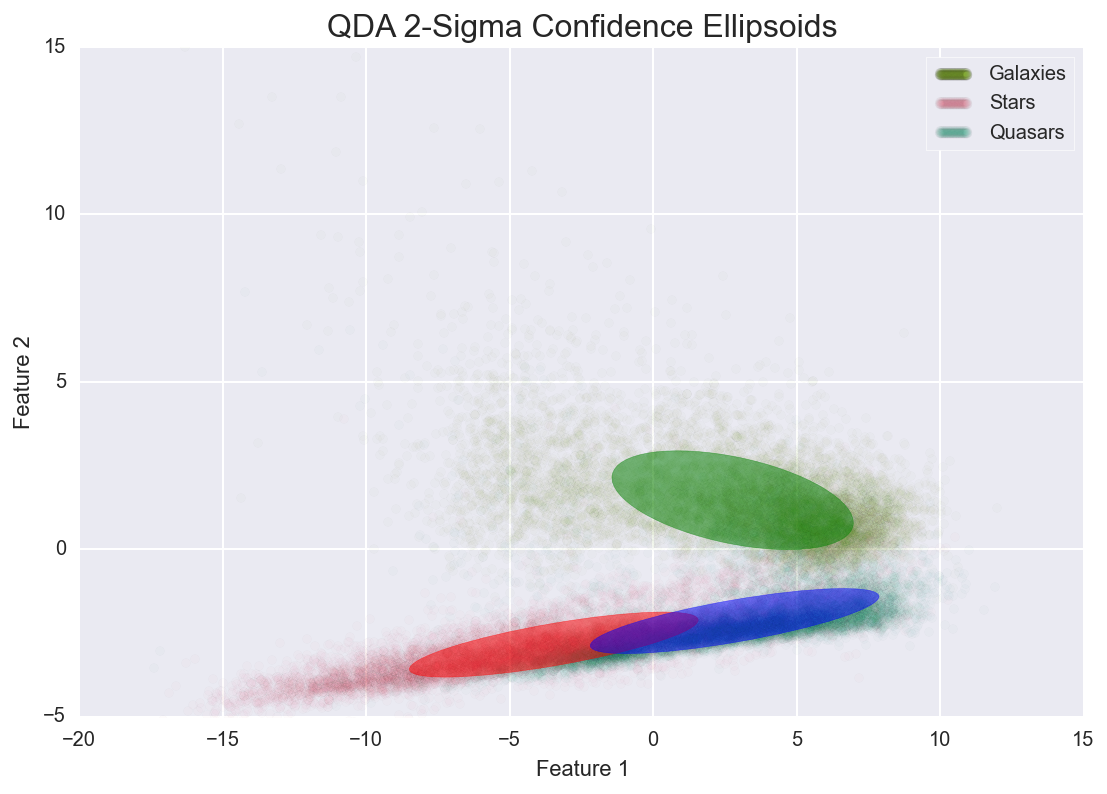

In [22]:
def plot_ellipse(splot, mean, cov, color):
    v, w = linalg.eigh(cov)
    u = w[0] / linalg.norm(w[0])
    angle = np.arctan(u[1] / u[0])
    angle = 180 * angle / np.pi  # convert to degrees
    # filled gaussian at 2 standard deviation
    ell = mpl.patches.Ellipse(mean, 2 * v[0] ** 0.5, 2 * v[1] ** 0.5,
                                            180 + angle, color=color)
    ell.set_clip_box(splot.bbox)
    ell.set_alpha(0.5)
    splot.add_artist(ell)

plt.figure(figsize=(9, 6))
splot = plt.subplot()

plt.scatter(subdata[subtarget == 0, 0], subdata[subtarget == 0, 1], c=colour_map[1], alpha=0.02)
plt.scatter(subdata[subtarget == 1, 0], subdata[subtarget == 1, 1], c=colour_map[0], alpha=0.02)
plt.scatter(subdata[subtarget == 2, 0], subdata[subtarget == 2, 1], c=colour_map[2], alpha=0.02)
plot_ellipse(splot, qda.means_[0], qda.covariances_[0], 'g')
plot_ellipse(splot, qda.means_[1], qda.covariances_[1], 'r')
plot_ellipse(splot, qda.means_[2], qda.covariances_[1], 'b')
plt.legend((s_galaxies, s_stars, s_quasars),
           ('Galaxies', 'Stars', 'Quasars'),
           scatterpoints=100,
           loc='upper right',
           frameon=True,
           ncol=1)
plt.ylim([-5, 15])
plt.xlim([-20, 15])
plt.title('Sloan Survey Data: PCA with 2 Dimensions')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.title('QDA 2-Sigma Confidence Ellipsoids')
plt.show()